#### run at startup

In [1]:
# need to run these at startup
mypath = "C:\Documents\Research Support Specialist\mRNA Project/"
%pip install Biopython
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd
import math as math

# Libraries to help with data visualization
import matplotlib.pyplot as plt # python library that offers flexibility
import seaborn as sns # lib built on matplot lib & provides ease of use fxns

# Command to tell Python to actually display the graphs
%matplotlib inline
# tells python to display graphs in our google notebook

import Bio
import re
from Bio.Seq import Seq
from Bio import SeqIO

Note: you may need to restart the kernel to use updated packages.


#### binding sites & dicts

In [3]:
## add more binding sites here as needed
binding_sites = {
'Whi3' : r'(?=(GCAT))',
'Ssd1' : r'(?=(C[AGCT][CT]TC[AGCT][CT]T))',
'KHD1_Piao' : r'(?=(CAACTACATCAAC))',
'KHD1_Wolf' : r'(?=(C[AT][AT]C[AT][AT]CA))',
'Puf3_Hogan' : r'(?=(TGTA[ACT]ATA))',
'Puf3_Gerber' : r'(?=(C[ACT]TGTA[AT]ATA))',
'Puf4_Gerber' : r'(?=(TTTGTA[CT]A[AT]TA))',
'Puf5_Gerber' : r'(?=(TTGTAA[CT]A[AT]TA))',
'Nrd1_GTAG' : r'(?=(GTAG))',
'Nrd1_GTAA' : r'(?=(GTAA))',
'Nrd1_TGTA' : r'(?=(TGTA))',
'Nab3_CTTG' : r'(?=(CTTG))',
'Nab3_TCTT' : r'(?=(TCTT))',
'Nab3_TCTTG' : r'(?=(TCTTG))',
'CSY4' : r'(?=(GTTCACTGCCGTATAGGCAGCTAAGAAA))'
}

# ORF
site_counts = {s:{} for s in binding_sites}
site_density = {s:{} for s in binding_sites}
lens = {s:{} for s in binding_sites}

# 5'UTR
site_counts_up = {s:{} for s in binding_sites}
site_density_up = {s:{} for s in binding_sites}
lens_up = {s:{} for s in binding_sites}

# 3'UTR
site_counts_down = {s:{} for s in binding_sites}
site_density_down = {s:{} for s in binding_sites}
lens_down = {s:{} for s in binding_sites}

In [4]:
# 5'UTR dataset to dict
gene_name = []
up_seq = []
for record in SeqIO.parse(mypath + "SGD_all_ORFs_5prime_UTRs.fsa", "fasta"):
    gene_name.append(record.id.split('_')[4])
    up_seq.append(str(record.seq))
up_utrs = dict(zip(gene_name, up_seq))

# 3'UTR dataset to dict
gene_name = []
up_seq = []
for record in SeqIO.parse(mypath + "SGD_all_ORFs_3prime_UTRs.fsa", "fasta"):
    gene_name.append(record.id.split('_')[4])
    up_seq.append(str(record.seq))
down_utrs = dict(zip(gene_name, up_seq))

#### density calculations

In [5]:
# orf density
for record in SeqIO.parse(mypath + "orf_coding_all.fasta", "fasta"):
    seq_str = str(record.seq)
    for protein, site in binding_sites.items():
        site_counts[protein][record.id] = len(re.findall(site, seq_str))
        lens[protein][record.id] = len(seq_str)
        site_density[protein][record.id] = site_counts[protein][record.id]/lens[protein][record.id]

site_dens = pd.DataFrame(site_density)
site_dens.reset_index(inplace=True)
site_dens.rename(columns={'index': 'gene'}, inplace=True)

In [6]:
# 5'UTR density
for g, s in up_utrs.items():
    for protein, site in binding_sites.items():
        site_counts_up[protein][g] = len(re.findall(site, s))
        lens_up[protein][g] = len(s)
        site_density_up[protein][g] = site_counts_up[protein][g]/lens_up[protein][g]

site_dens_up = pd.DataFrame(site_density_up)
site_dens_up.reset_index(inplace=True)
site_dens_up.rename(columns={'index': 'gene'}, inplace=True)

In [7]:
# 3'UTR density
for g, s in down_utrs.items():
    for protein, site in binding_sites.items():
        site_counts_down[protein][g] = len(re.findall(site, s))
        lens_down[protein][g] = len(s)
        site_density_down[protein][g] = site_counts_down[protein][g]/lens_down[protein][g]

site_dens_down = pd.DataFrame(site_density_down)
site_dens_down.reset_index(inplace=True)
site_dens_down.rename(columns={'index': 'gene'}, inplace=True)

#### half lives dataset

In [8]:
half_lives_og = pd.read_excel(mypath + 'RNA Half-lives (ranked)(Both Names) Alalam_Sunnerhagen.xlsx', header=None)
half_lives_og = half_lives_og.set_axis(['gene', 'n/a', 'half life (min)', 'n/a', 'n/a', 'protein'], axis=1)
half_lives = half_lives_og[['gene', 'half life (min)', 'protein']]
half_lives = half_lives.dropna(subset=['gene', 'half life (min)'])

In [9]:
comb = pd.merge(site_dens, half_lives, how='inner', on='gene')
comb_up = pd.merge(site_dens_up, half_lives, how='inner', on='gene')
comb_down = pd.merge(site_dens_down, half_lives, how='inner', on='gene')
comb['region'] = 'ORF'
comb_up['region'] = "5' UTR"
comb_down['region'] = "3' UTR"

#### visualization function

In [10]:
def see_data_neat(df):
    col = 4
    row = math.ceil(len(binding_sites)/col)
    fig1, axes = plt.subplots(row, col, figsize=(6*col, 4*row))
    for i, (ax, k) in enumerate(zip(axes.flat, binding_sites.keys())):
        sns.scatterplot(data=df, x='half life (min)', y=k, alpha=0.1, s=20, ax=ax)
        ax.set_title(f"{k} and {df['region'][0]}")
    for j in range(i+1, row*col):
        fig1.delaxes(axes.flat[j])
    plt.tight_layout()
    plt.show()
    fig2, axes = plt.subplots(row, col, figsize=(6*col, 4*row))
    for i, (ax, k) in enumerate(zip(axes.flat, binding_sites.keys())):
        ax.hist2d(df['half life (min)'], df[k], bins=(80, 80), cmap='Blues')
        ax.set_title(f"{k} and {df['region'][0]}")
        ax.set_xlabel('half life (min)'), ax.set_ylabel(f'{k}')
    for j in range(i+1, row*col):
        fig2.delaxes(axes.flat[j])
    plt.tight_layout()
    plt.show()
    corr = df.corr(numeric_only=True, method='spearman')
    nonzero = df.replace(0, np.nan)
    corr_nonzero = nonzero.corr(numeric_only=True, method='spearman')
    corr_tg = pd.concat([corr['half life (min)'],corr_nonzero['half life (min)']], axis=1)
    corr_tg.columns = ['Correlation with Half Life', 'Nonzero Density Correlation with Half Life']
    return corr_tg.T.style.format(precision=3)


In [ ]:
# [corr['half life (min)'].to_frame().T.style.format(precision=3),corr_nonzero['half life (min)'].to_frame().T.style.format(precision=3)]

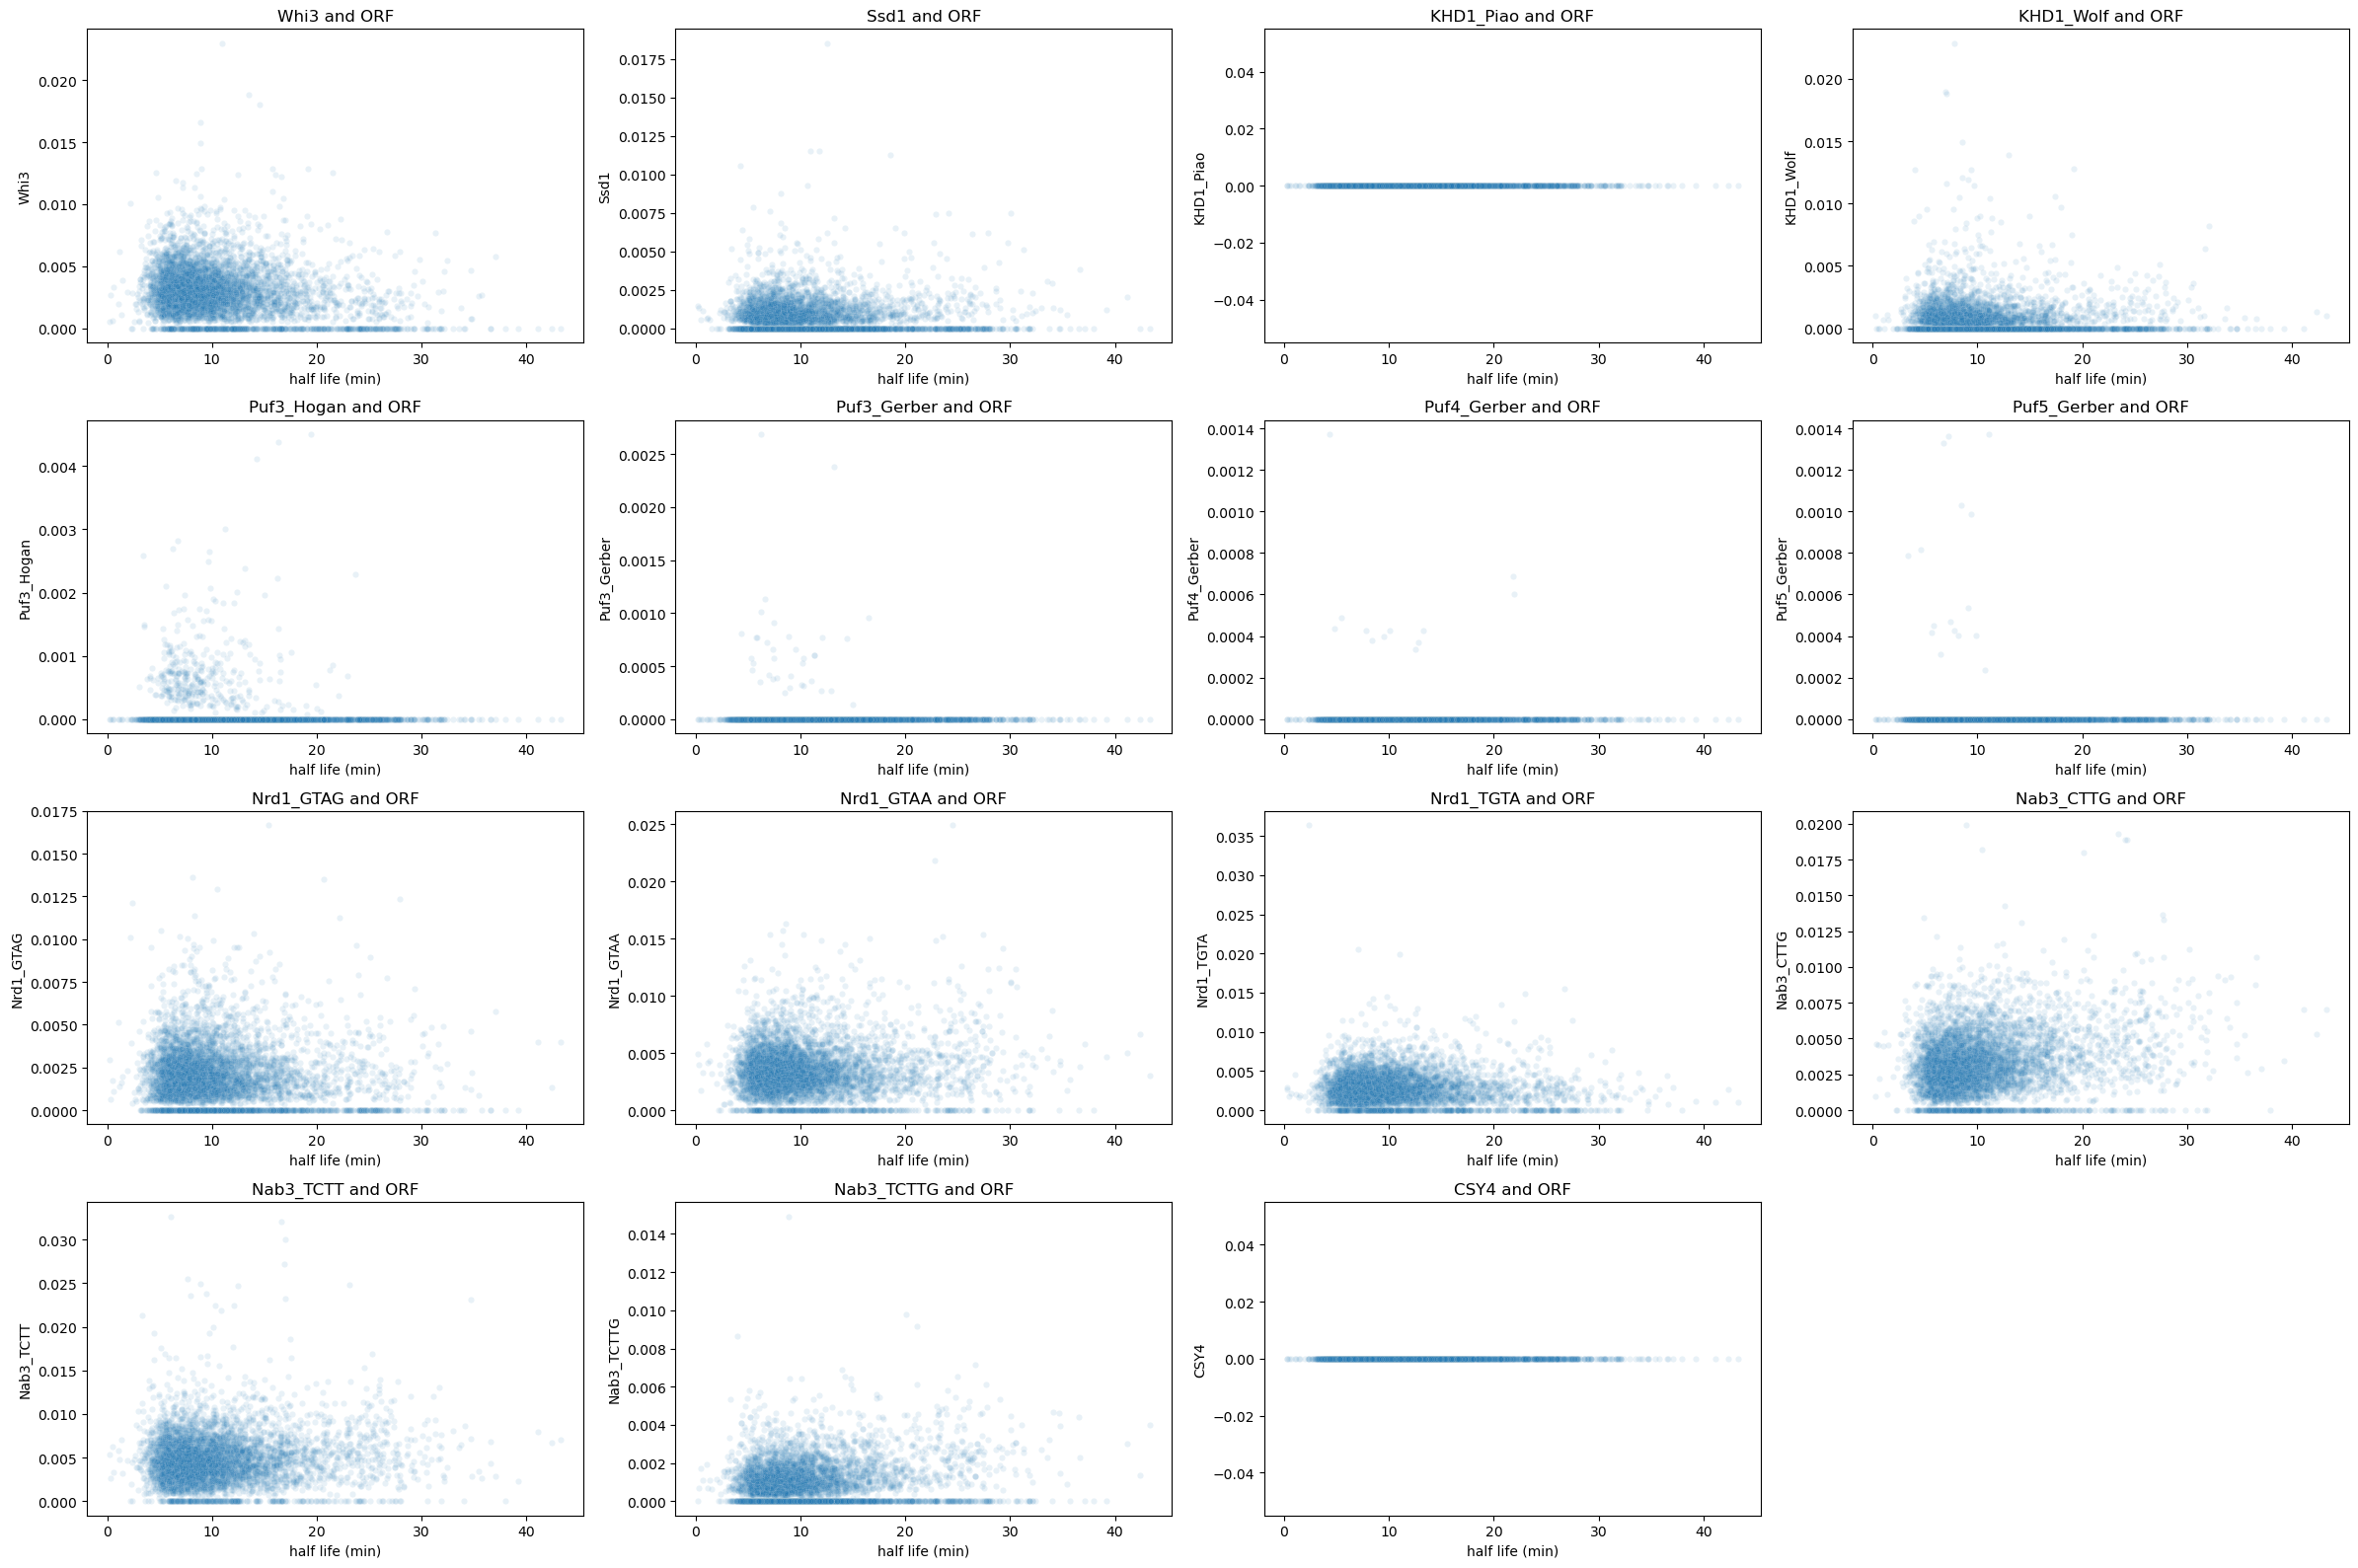

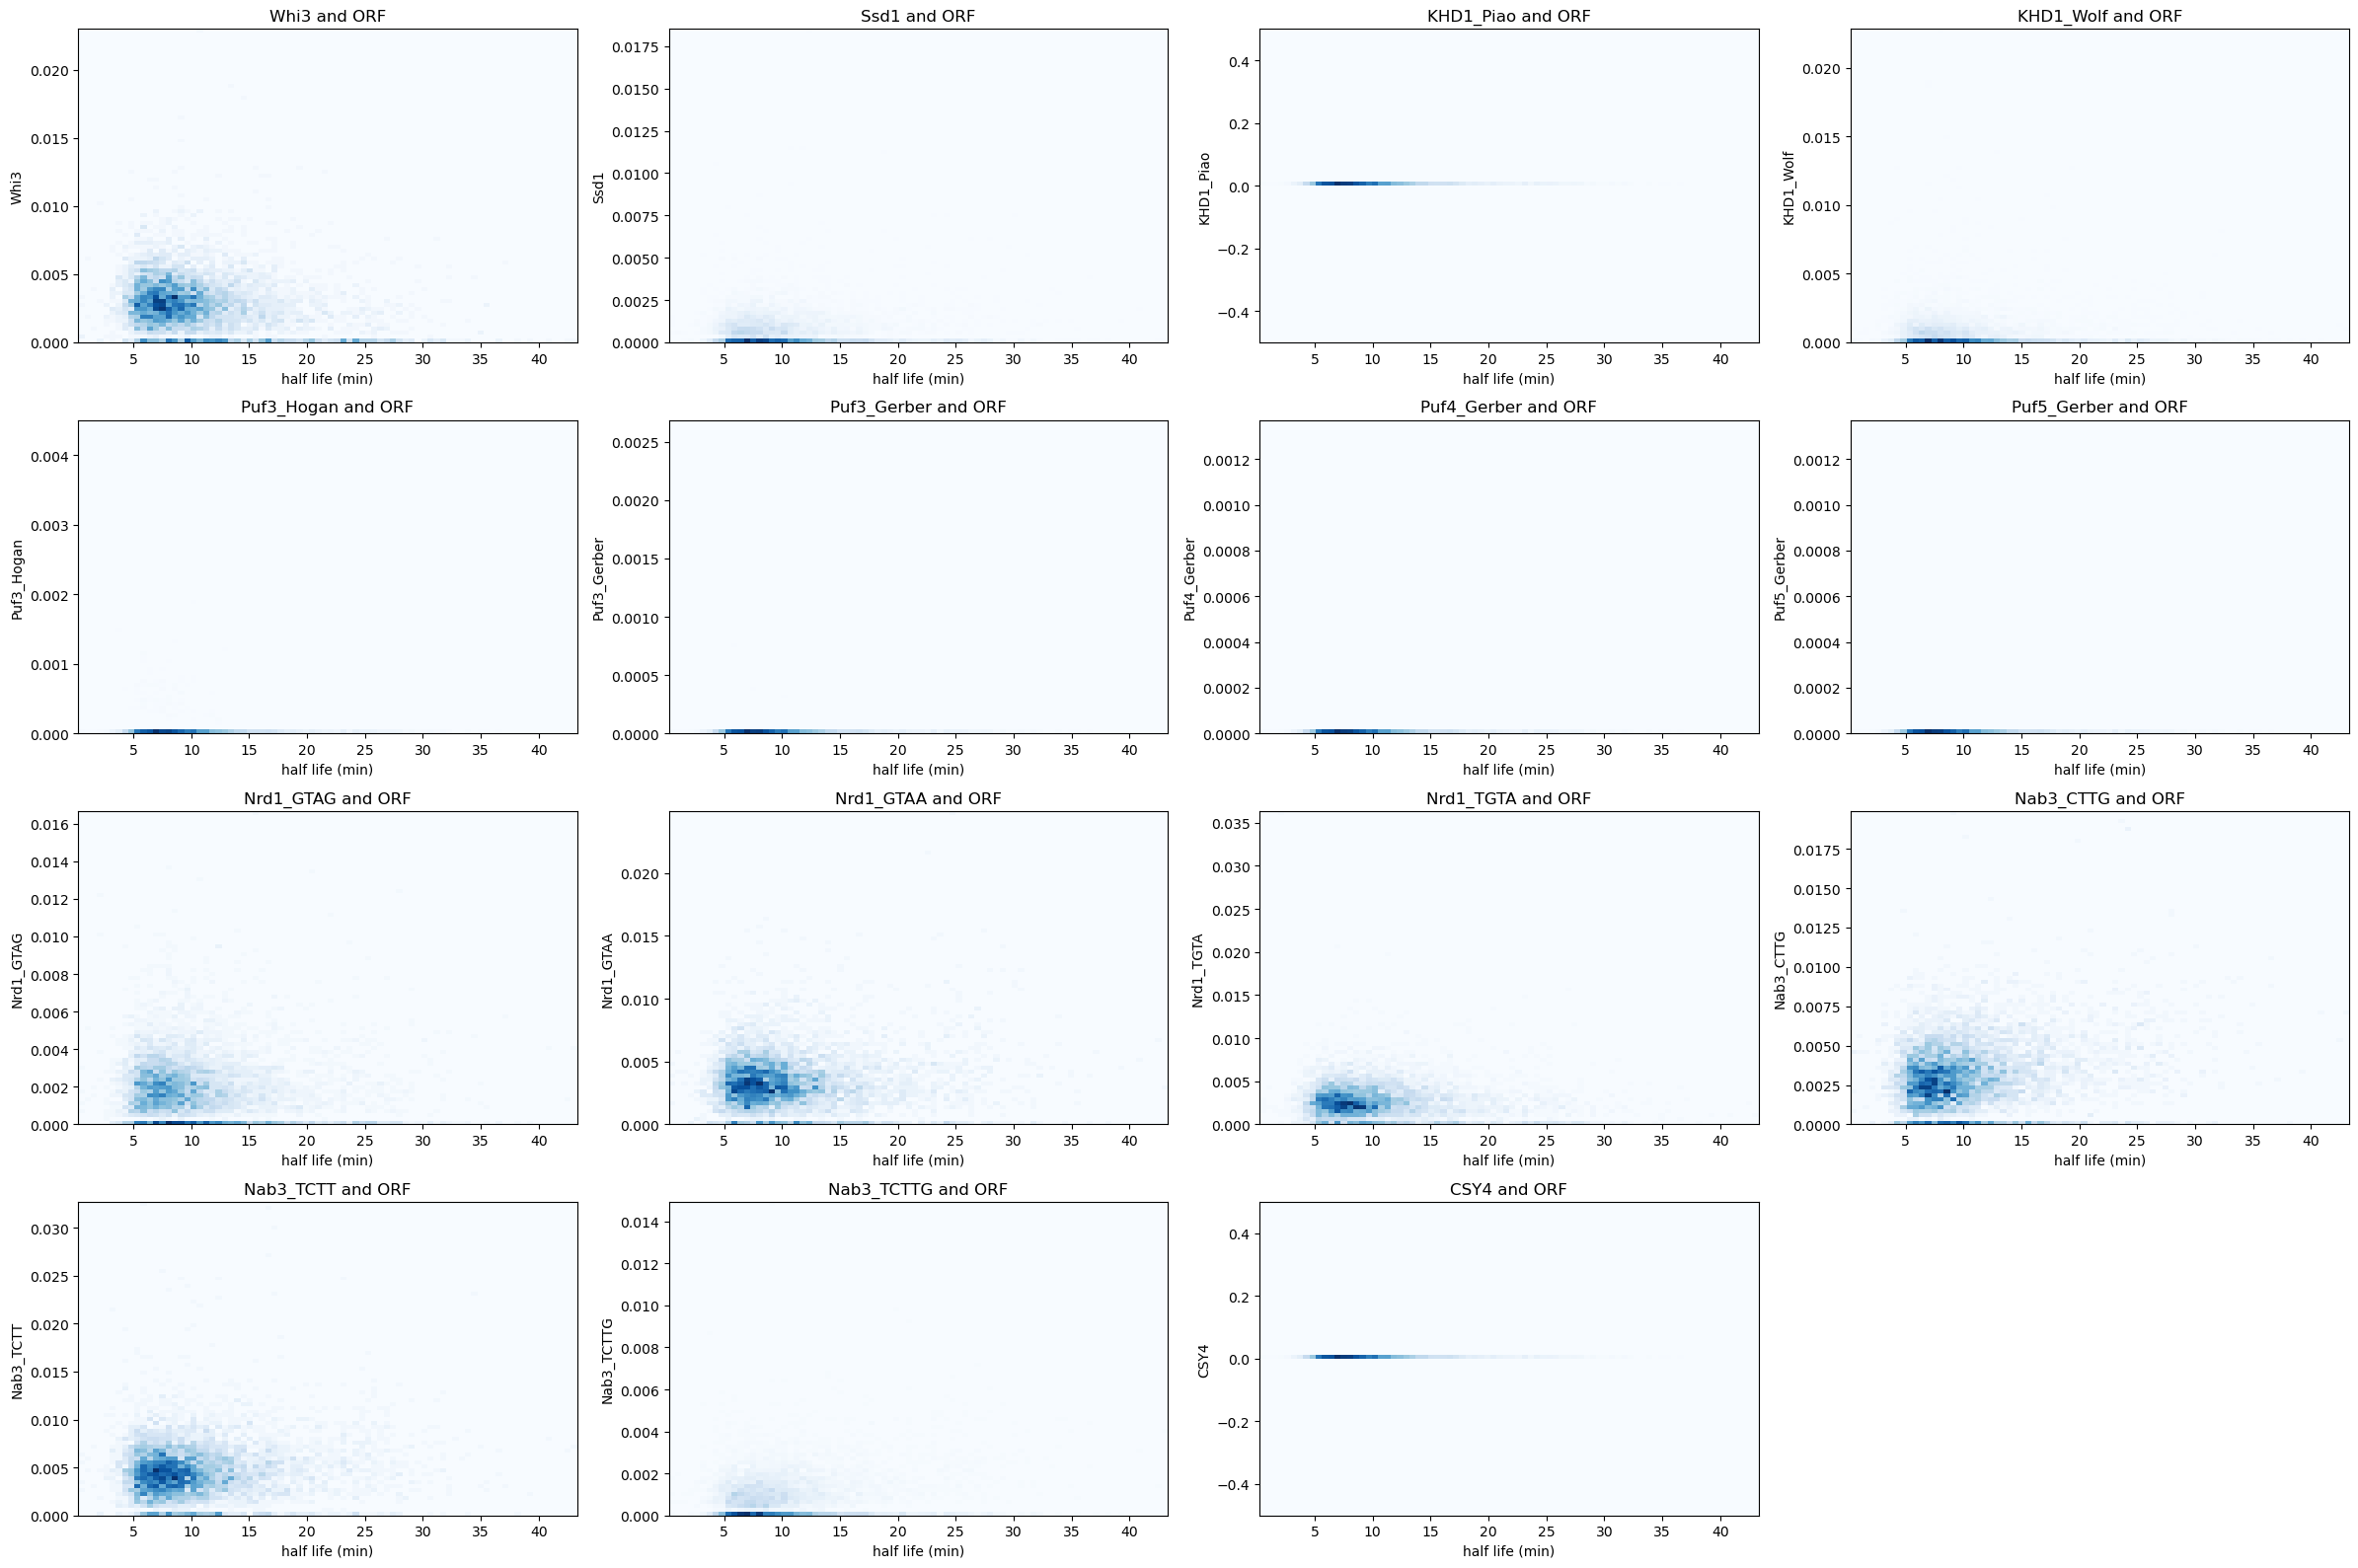

,Whi3,Ssd1,KHD1_Piao,KHD1_Wolf,Puf3_Hogan,Puf3_Gerber,Puf4_Gerber,Puf5_Gerber,Nrd1_GTAG,Nrd1_GTAA,Nrd1_TGTA,Nab3_CTTG,Nab3_TCTT,Nab3_TCTTG,CSY4,half life (min)
Correlation with Half Life,-0.190,-0.049,nan,-0.092,-0.060,-0.019,0.003,-0.032,-0.098,-0.019,-0.059,0.162,0.044,0.103,nan,1.000
Nonzero Density Correlation with Half Life,-0.075,0.096,nan,0.011,-0.101,-0.201,-0.161,-0.012,0.014,0.033,0.029,0.224,0.079,0.240,nan,1.000


In [11]:
see_data_neat(comb)

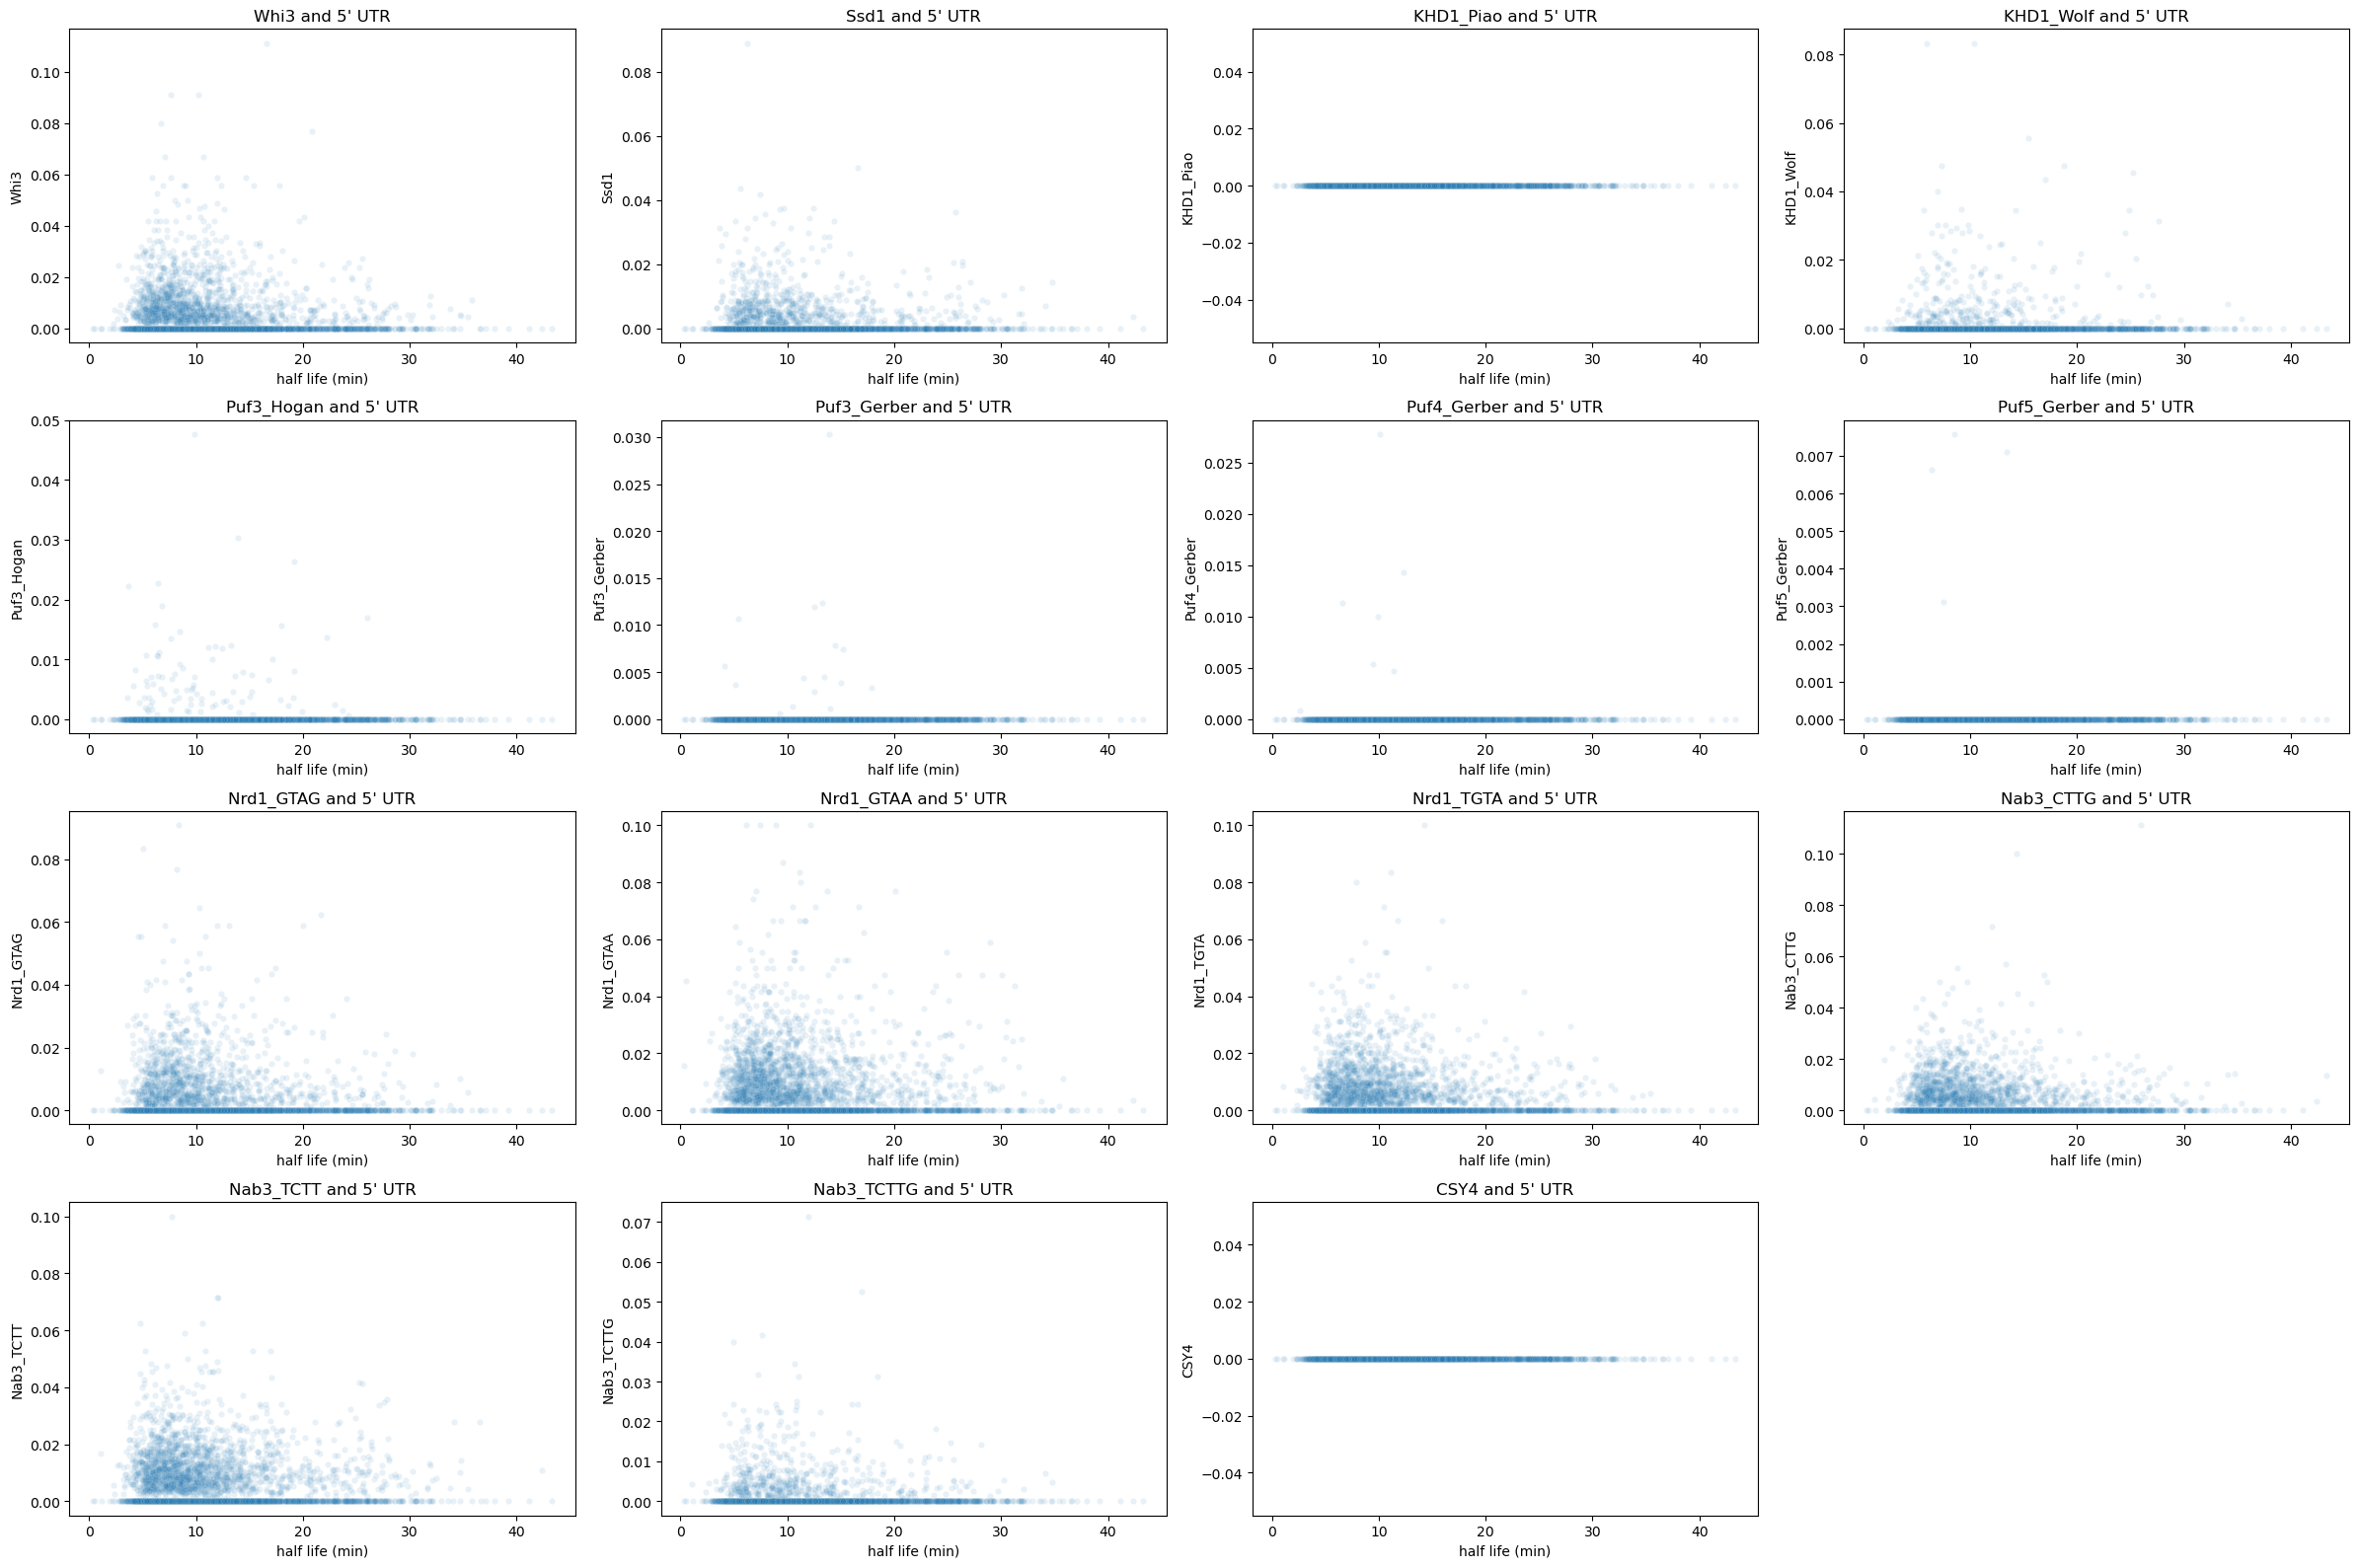

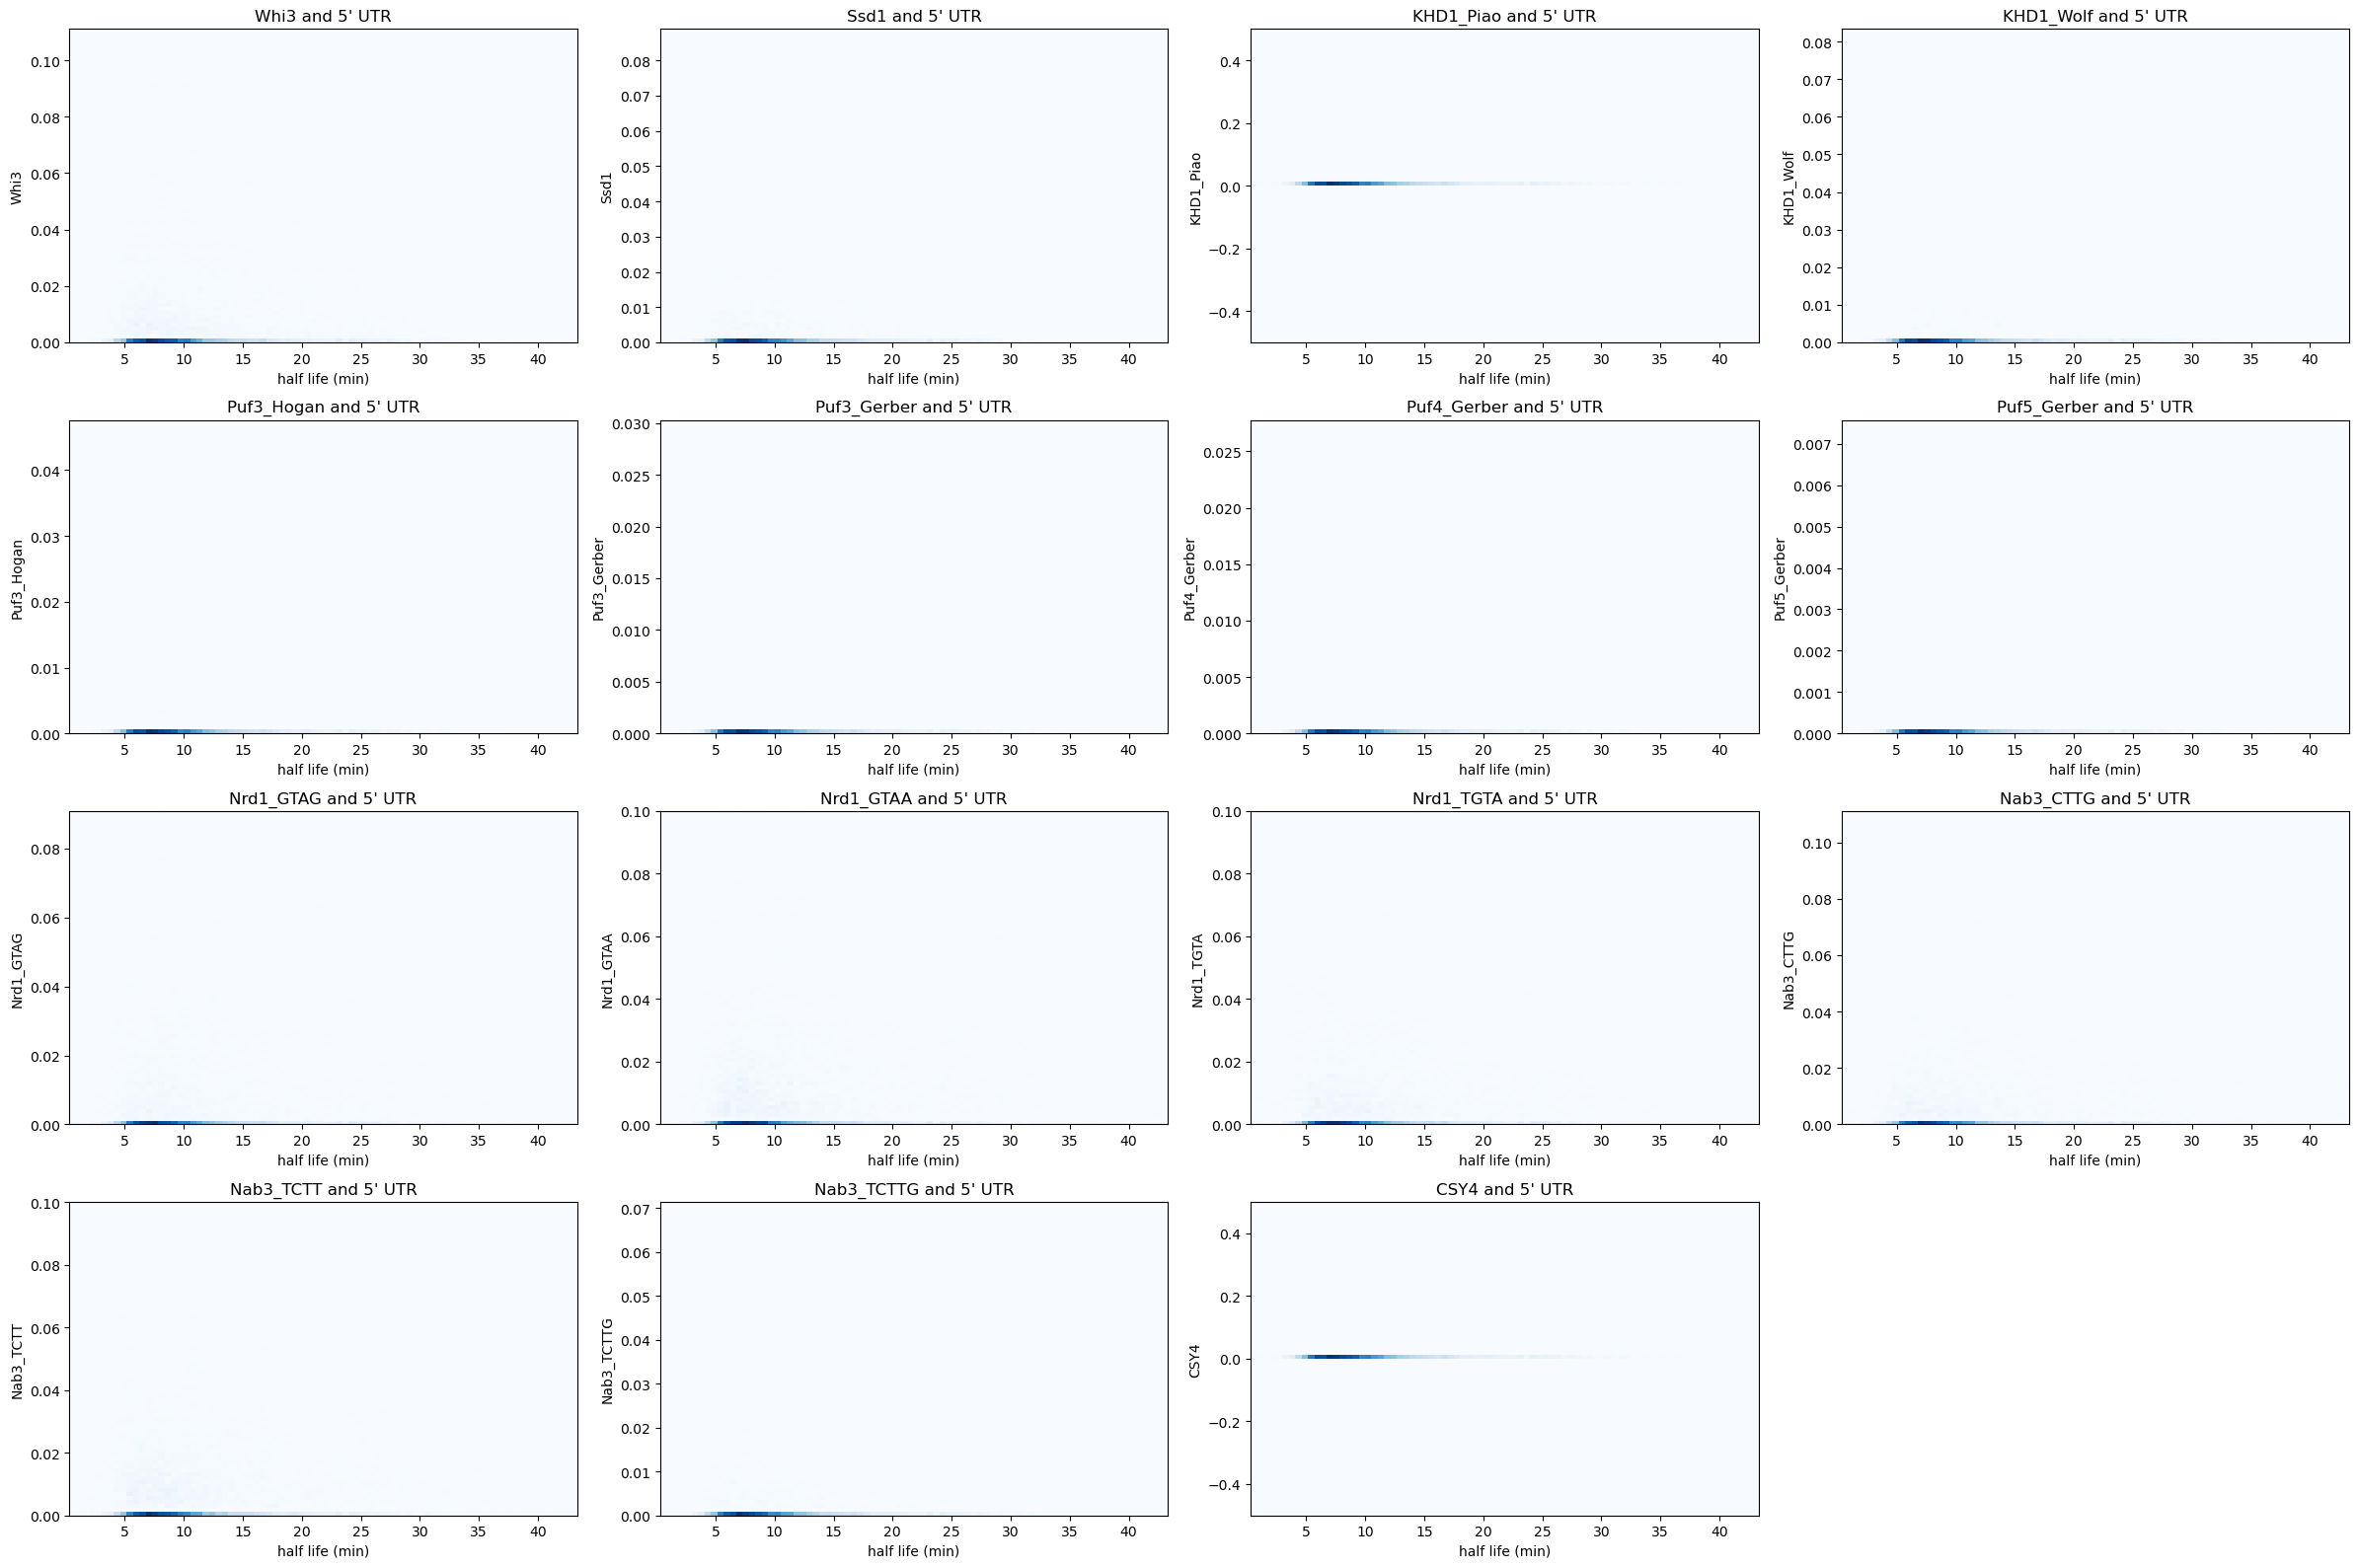

,Whi3,Ssd1,KHD1_Piao,KHD1_Wolf,Puf3_Hogan,Puf3_Gerber,Puf4_Gerber,Puf5_Gerber,Nrd1_GTAG,Nrd1_GTAA,Nrd1_TGTA,Nab3_CTTG,Nab3_TCTT,Nab3_TCTTG,CSY4,half life (min)
Correlation with Half Life,-0.029,0.005,nan,0.035,0.000,0.024,-0.004,-0.007,-0.011,-0.003,-0.001,-0.008,-0.004,0.018,nan,1.000
Nonzero Density Correlation with Half Life,-0.099,-0.078,nan,0.013,-0.029,0.076,0.464,0.600,-0.061,-0.015,-0.058,-0.060,-0.036,-0.050,nan,1.000


In [12]:
see_data_neat(comb_up)

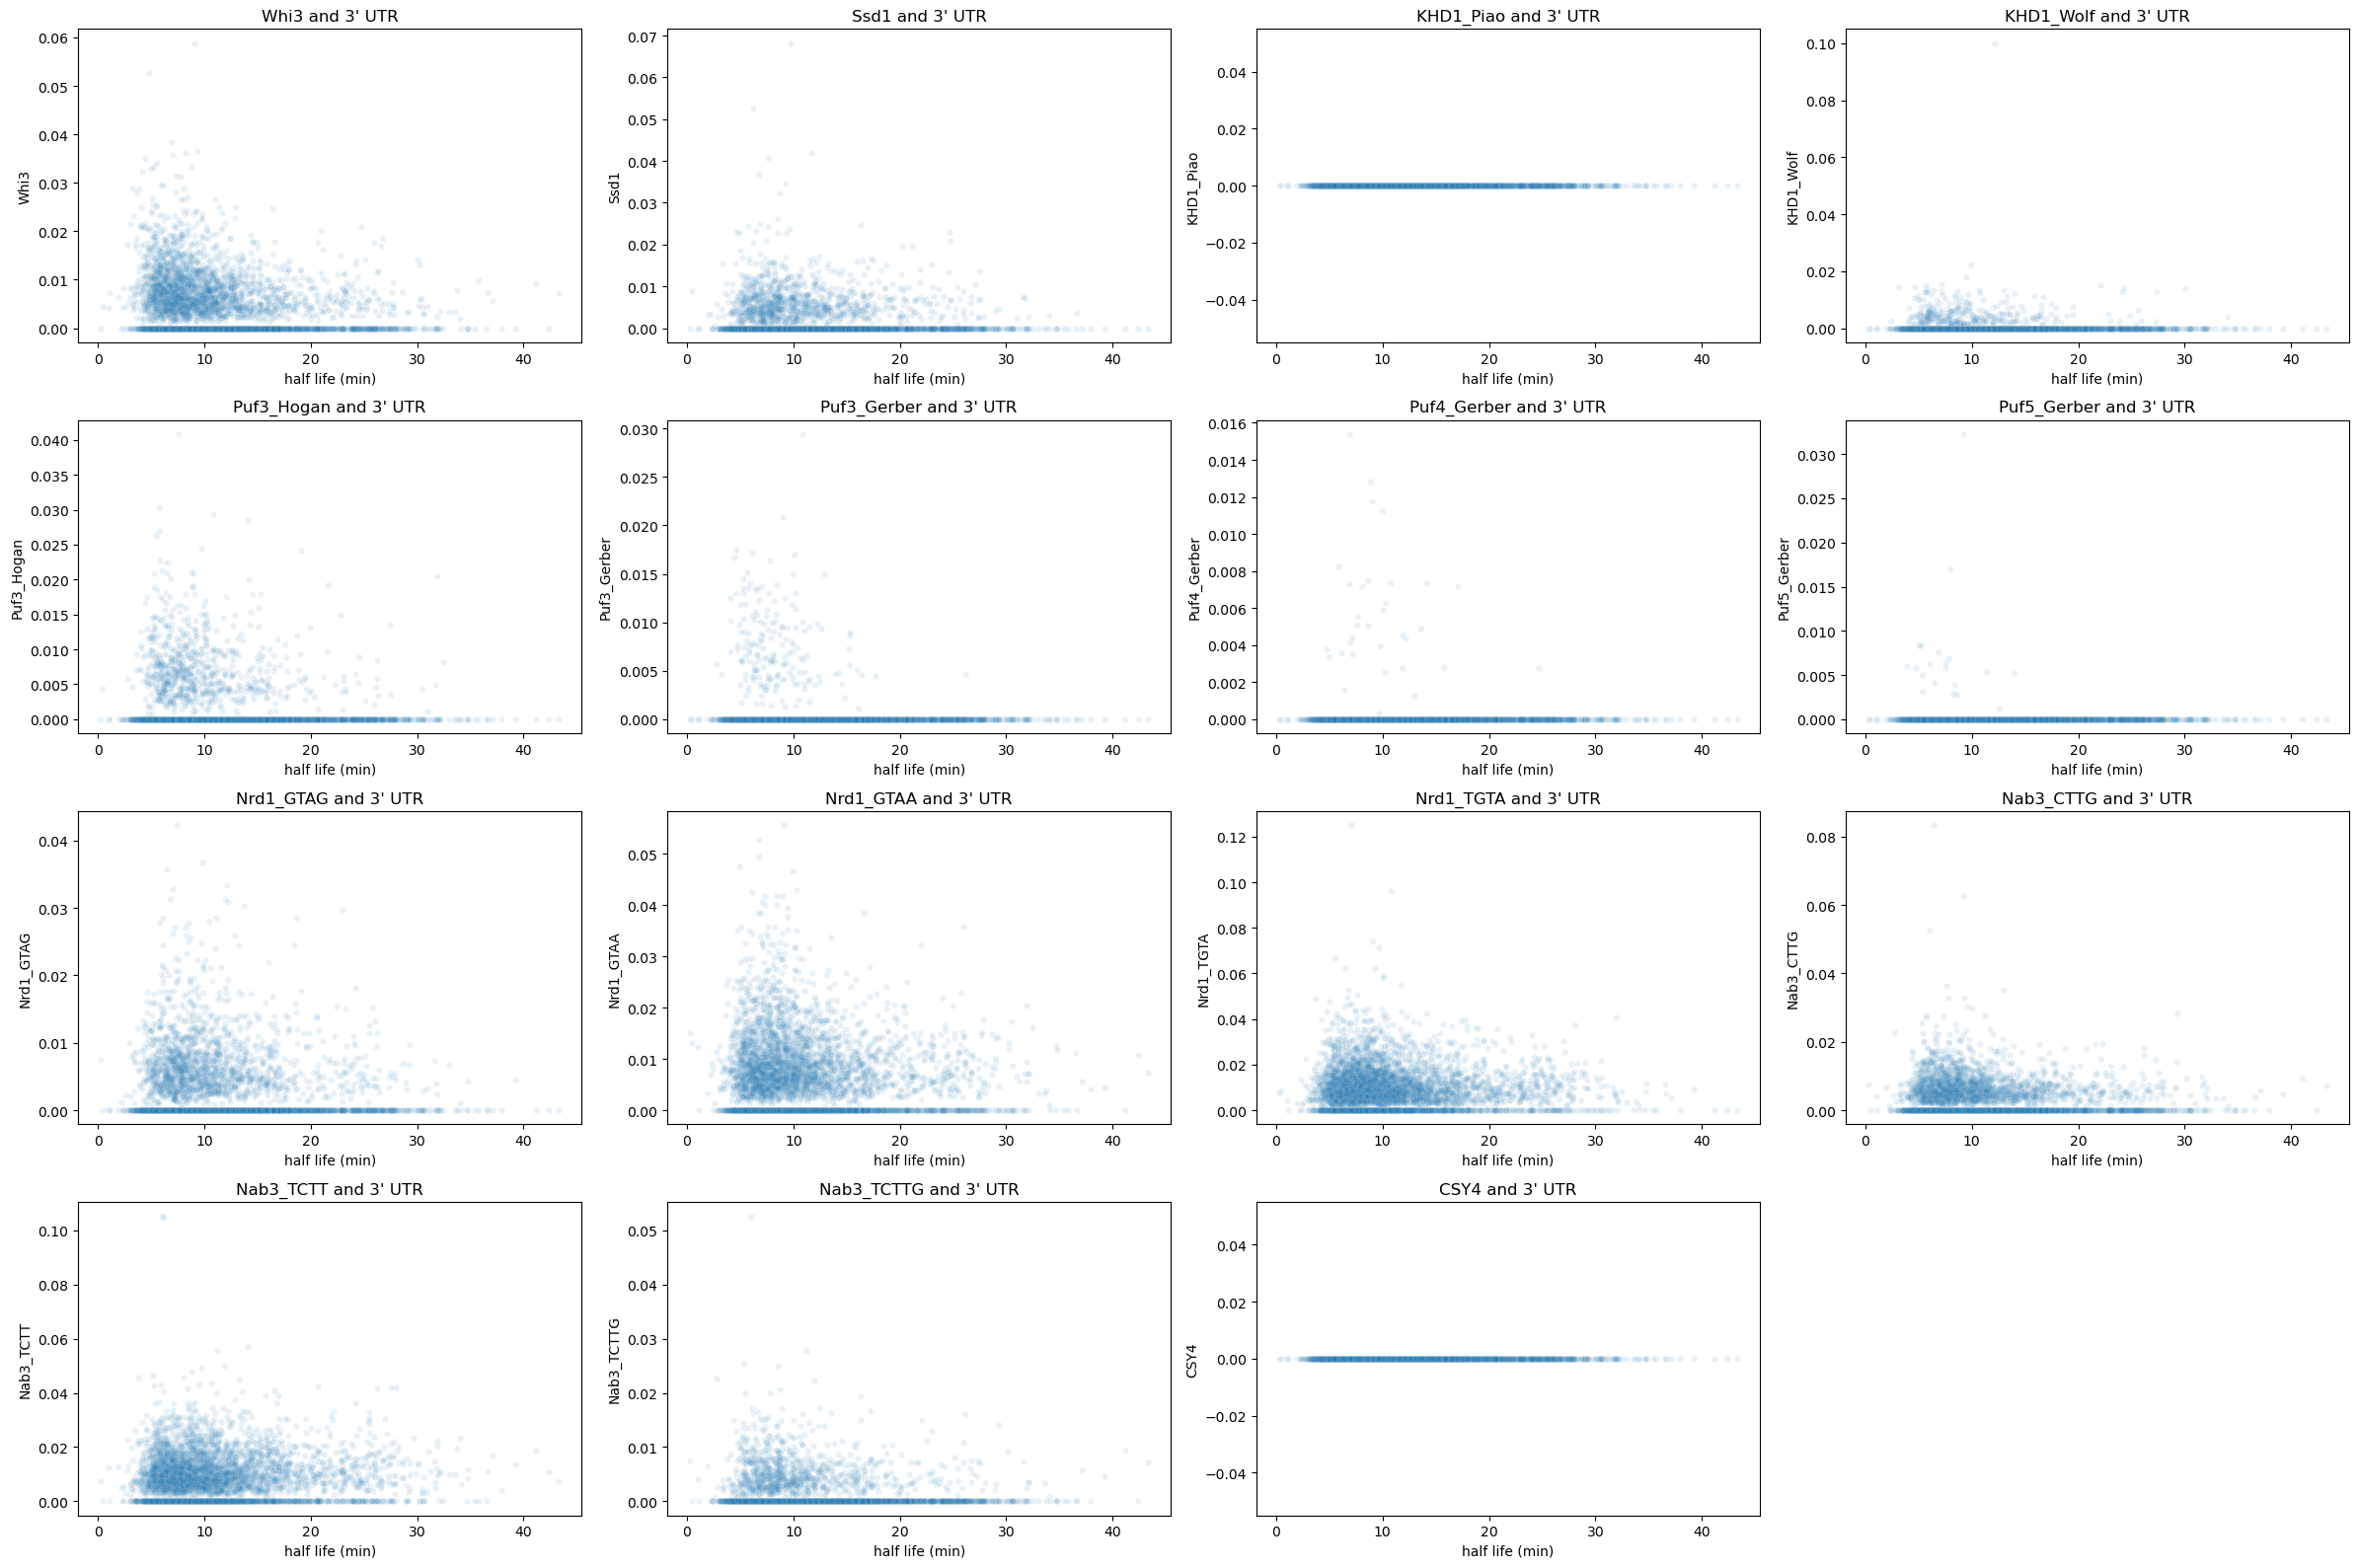

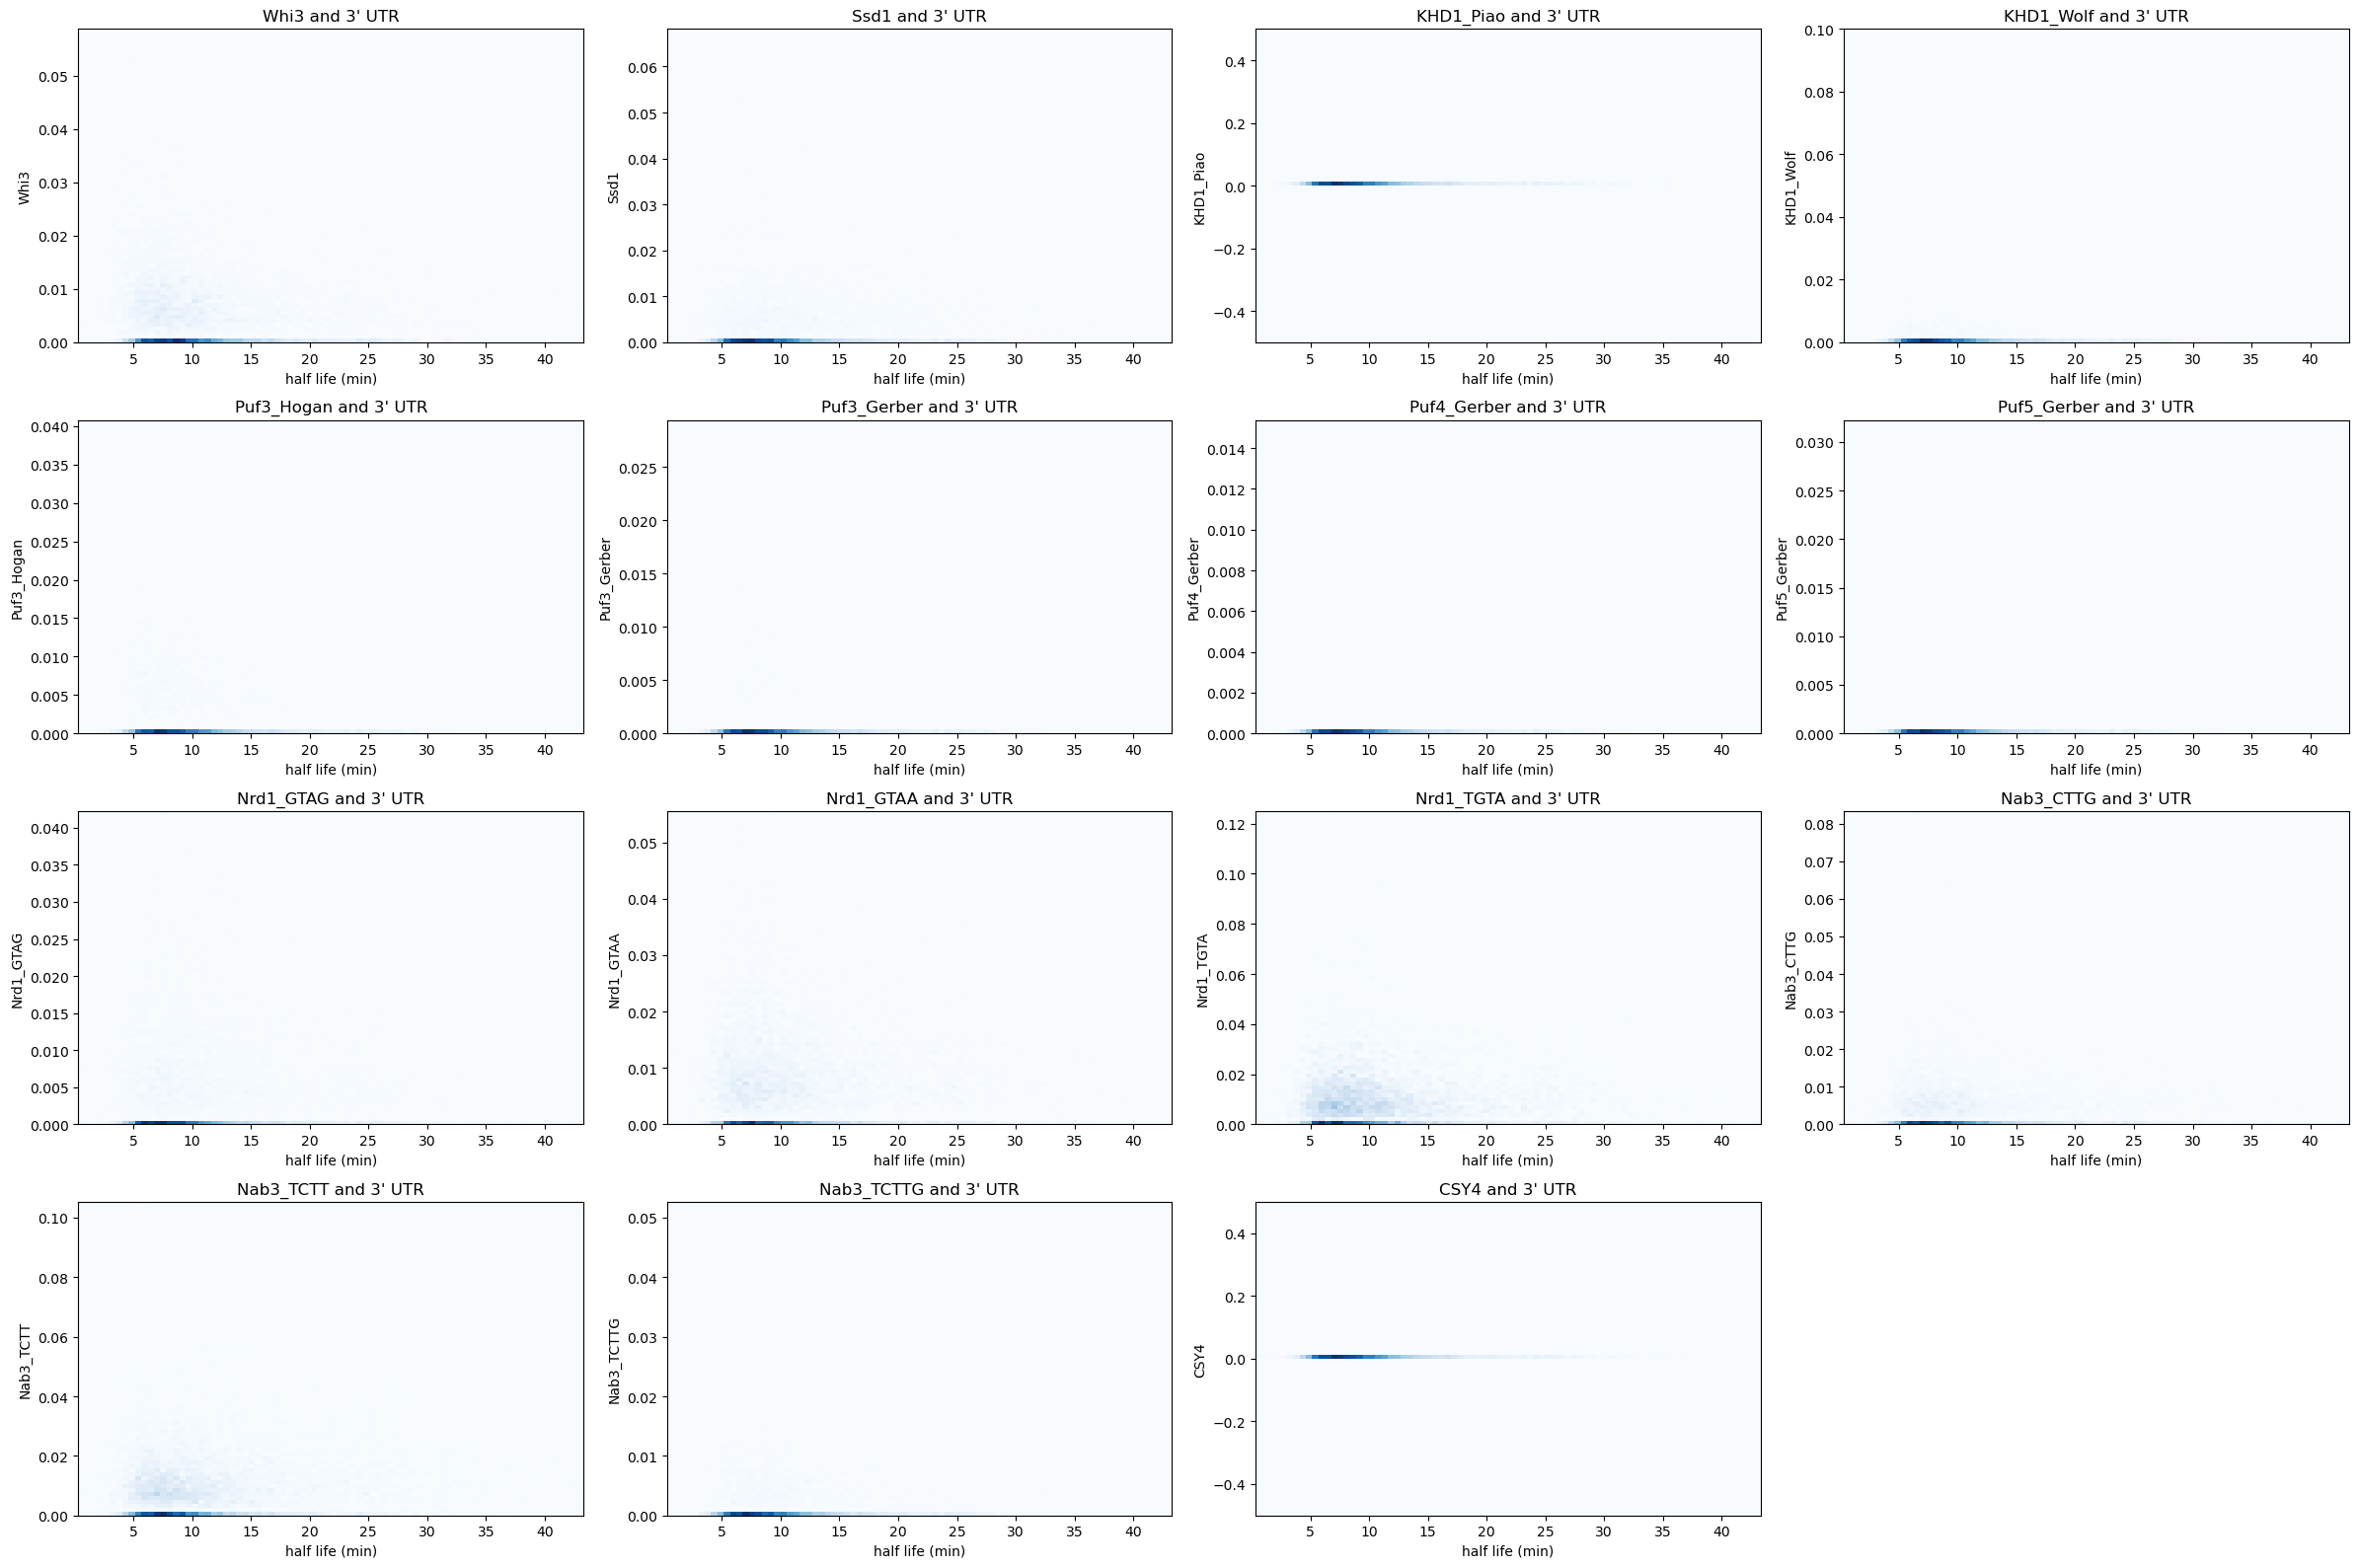

,Whi3,Ssd1,KHD1_Piao,KHD1_Wolf,Puf3_Hogan,Puf3_Gerber,Puf4_Gerber,Puf5_Gerber,Nrd1_GTAG,Nrd1_GTAA,Nrd1_TGTA,Nab3_CTTG,Nab3_TCTT,Nab3_TCTTG,CSY4,half life (min)
Correlation with Half Life,-0.169,0.017,nan,-0.031,-0.077,-0.089,-0.005,-0.042,0.011,-0.026,0.016,-0.013,0.073,0.000,nan,1.000
Nonzero Density Correlation with Half Life,-0.175,0.000,nan,-0.020,-0.129,-0.202,-0.092,-0.294,-0.057,-0.049,-0.017,-0.062,0.044,-0.032,nan,1.000


In [13]:
see_data_neat(comb_down)